In [10]:
spark.stop()

In [60]:
#-------------------------------------------------------------------------------------------------------------------------------
import pandas as pd
from pyspark import SparkContext                                    # Importing SparkContext
from pyspark.sql import SparkSession, Window, Row                   # Importing importing methods for creating a cluster
from pyspark.sql import functions as F                              # Importing SQL Functions
from pyspark.sql.functions import col, isnan, when, count           # Importing relevant dataframe functions
from pyspark.sql.functions import *                                 # Importing inbuilt SQL Functions
from pyspark.sql.types import *                                     # Importing SQL types
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     # Popular plotting library
% matplotlib inline                                                  # To plot graphs inline the notebook
import seaborn as sns                                               # Advanced plotting library
from handyspark import *                                            # Helper library to plot graphs
#-------------------------------------------------------------------------------------------------------------------------------
from pyspark.ml.feature import VectorAssembler                      # For processing dataset for ML
#-------------------------------------------------------------------------------------------------------------------------------
import warnings                                                     # Importing warning to disable runtime warnings
warnings.filterwarnings("ignore")                                   # Warnings will appear only once
#-------------------------------------------------------------------------------------------------------------------------------

UsageError: Line magic function `%` not found.


In [61]:
# Intialization
import os
import sys

os.environ["SPARK_HOME"] = "/home/talentum/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.6" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

# NOTE: Whichever package you want mention here.
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0 pyspark-shell' 
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.3 pyspark-shell'
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'

In [62]:
#Entrypoint 2.x
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Finding Insights").enableHiveSupport().getOrCreate()



# On yarn:
# spark = SparkSession.builder.appName("Spark SQL basic example").enableHiveSupport().master("yarn").getOrCreate()
# specify .master("yarn")

sc = spark.sparkContext

In [69]:
filepath = "file:///home/talentum/myproject/dataSource/output/tableau/*.csv"
df = spark.read.csv(filepath, header=True, inferSchema=True)
df_count = df.count()
print(df_count)
# fraction = 1.0 if df_count == 0 else min(1.0, 1000000 / df_count)

# # Sample rows randomly from the DataFrame using the calculated fraction
# df_sampled = df.sample(fraction=fraction, seed=42)

# # Limit the number of rows in the sampled DataFrame to 500,000
# df_limited = df_sampled.limit(500000)
# Read the CSV files into a DataFrame


# Sample 10,000 random rows
sampled_df = df.orderBy(rand()).limit(100000)
df = sampled_df
df=df.persist()
print(df.count())


12016500
100000


In [70]:
from pyspark.sql.functions import to_timestamp

# assume 'df' is your PySpark DataFrame and 'source' is your column name
df = df.withColumn("from_date", to_timestamp(df["from_date"], "dd-MM-yyyy"))
df= df.withColumn("to_date", to_timestamp(df["to_date"], "dd-MM-yyyy"))

In [71]:
columns_to_cast = [c for c in df.columns if c not in ['state','from_date','to_date']]
for c in columns_to_cast:
    df = df.withColumn(c, col(c).cast("double"))    

In [72]:
numerical_columns_new = [col[0] for col in df.dtypes if col[1] in ("IntegerType", "double")]
string_columns_new = [col[0] for col in df.dtypes if col[1] == "string"]

print("All Numerial columns:")
print(numerical_columns_new)
print("\n")
print("All string columns:")
print(string_columns_new)

All Numerial columns:
['bp_mmhg', 'benzene_ug_m3', 'mp_xylene_ug_m3', 'o_xylene_ug_m3', 'co_mg_m3', 'nh3_ug_m3', 'so2_ug_m3', 'temp_degree_c', 'wd_deg', 'nox_ppb', 'no_ug_m3', 'toluene_ug_m3', 'ozone_ug_m3', 'pm10_ug_m3', 'sr_w_mt2', 'ws_m_s', 'no2_ug_m3', 'pm2_5_ug_m3', 'rh_%', 'AQI_Category']


All string columns:
['state']


In [73]:
df1=df

In [74]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, lit

# Initialize Spark session (if not already initialized)
spark = SparkSession.builder.appName("NullPercentage").getOrCreate()

# Create a DataFrame (assuming it's already loaded as 'df')

# Define a function to calculate null percentages for numeric and non-numeric columns
def calculate_null_percentage(df):
    total_count = df.count()
    exprs = []

    for c in df.columns:
        if dict(df.dtypes)[c] in ['double', 'float', 'int']:
            exprs.append((count(when(col(c).isNull() | isnan(c), c)) / total_count).alias(c))
        else:
            exprs.append((count(when(col(c).isNull(), c)) / total_count).alias(c))

    return df.select(exprs)

# Calculate the null percentage for each column
null_percentage_df = calculate_null_percentage(df1)

# Show the null percentages
null_percentage_df.toPandas().transpose()


,0
bp_mmhg,0.0
benzene_ug_m3,0.0
mp_xylene_ug_m3,0.0
o_xylene_ug_m3,0.0
co_mg_m3,0.0
nh3_ug_m3,0.0
so2_ug_m3,0.0
temp_degree_c,0.0
from_date,0.0
state,0.0


In [75]:
# Convert the null percentage DataFrame to a dictionary for easy access
null_percentages = null_percentage_df.collect()[0].asDict()

# Define the threshold for dropping columns (50% in this case)
threshold = 0.50

# Select the columns to keep (those with null percentage <= 50%)
columns_to_keep = [col for col, pct in null_percentages.items() if pct <= threshold]
print("Columns to keep:")
print(columns_to_keep)

# Create a new DataFrame with the selected columns
df_filtered = df.select(columns_to_keep)

# Show the new DataFrame
#df_filtered.show(truncate=False)
df_filtered.toPandas()

Columns to keep:
['bp_mmhg', 'benzene_ug_m3', 'mp_xylene_ug_m3', 'o_xylene_ug_m3', 'co_mg_m3', 'nh3_ug_m3', 'so2_ug_m3', 'temp_degree_c', 'from_date', 'state', 'wd_deg', 'nox_ppb', 'no_ug_m3', 'toluene_ug_m3', 'to_date', 'ozone_ug_m3', 'pm10_ug_m3', 'sr_w_mt2', 'ws_m_s', 'no2_ug_m3', 'pm2_5_ug_m3', 'rh_%']


,bp_mmhg,benzene_ug_m3,mp_xylene_ug_m3,o_xylene_ug_m3,co_mg_m3,nh3_ug_m3,so2_ug_m3,temp_degree_c,from_date,state,...,no_ug_m3,toluene_ug_m3,to_date,ozone_ug_m3,pm10_ug_m3,sr_w_mt2,ws_m_s,no2_ug_m3,pm2_5_ug_m3,rh_%
0,739.00,3.02,1.80,28.57,2.23,8.32,3.82,27.95,2018-07-28,Uttar Pradesh,...,9.82,37.85,2018-07-28,1.92,41.25,7.00,0.30,30.38,53.24,75.00
1,998.33,0.38,2.19,0.00,0.73,11.90,6.03,29.07,2022-01-05,Tamil Nadu,...,4.74,0.00,2022-01-05,78.50,47.75,71.03,1.90,12.15,16.75,63.77
2,268.86,62.19,2.10,2.65,1.60,15.83,8.13,0.39,2022-05-11,Maharashtra,...,2.60,0.60,2022-05-11,0.59,95.20,4.03,0.67,26.85,61.01,0.73
3,27.45,3.02,56.33,0.33,2.23,16.90,16.43,230.18,2022-04-04,Delhi,...,8.43,9.83,2022-04-04,17.57,194.75,4.92,976.85,94.50,72.75,5.05
4,19.08,11.65,0.75,2.65,6.28,15.83,33.21,27.95,2022-04-26,Gujarat,...,6.87,3.53,2022-04-26,0.01,90.65,131.85,3.90,10.05,54.05,42.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.70,0.63,2.19,2.65,0.84,15.83,15.21,3.14,2018-10-08,Haryana,...,229.38,15.79,2018-10-08,6.20,90.50,41.44,1.59,9.34,109.22,6.37
99996,1008.87,0.00,2.19,27.78,0.42,11.90,3.29,31.39,2017-11-10,Tamil Nadu,...,3.30,2.08,2017-11-10,19.12,48.90,0.00,0.94,20.77,45.65,61.16
99997,25.68,0.60,2.19,2.65,0.60,1.02,18.60,29.93,2021-10-18,Madhya Pradesh,...,21.32,1.63,2021-10-18,32.20,79.25,28.19,2.92,46.00,48.75,16.95
99998,0.17,1.52,2.19,2.65,12.57,15.83,51.58,27.95,2020-11-13,Bihar,...,183.63,9.52,2020-11-13,3.94,90.50,84.86,0.52,39.51,109.28,4.87


## Imputing null values

In [76]:
from pyspark.sql.types import IntegerType, FloatType, DoubleType
from pyspark.ml.feature import Imputer

numeric_column_names = [column.name for column in df_filtered.schema.fields
                        if isinstance(column.dataType, (IntegerType, FloatType, DoubleType))]


# Initialize the Imputer
imputer = Imputer(
    inputCols= numeric_column_names, #specifying the input column names
    outputCols=numeric_column_names, #specifying the output column names
    strategy="median"                  # or "median" if you want to use the median value
)

# Fit the Imputer
model = imputer.fit(df_filtered)

#Transform the dataset
imputed_df = model.transform(df_filtered)


In [77]:
# Check: After Imputing percentage of null values
new_df=calculate_null_percentage(imputed_df)
new_df.toPandas().transpose()

,0
bp_mmhg,0.0
benzene_ug_m3,0.0
mp_xylene_ug_m3,0.0
o_xylene_ug_m3,0.0
co_mg_m3,0.0
nh3_ug_m3,0.0
so2_ug_m3,0.0
temp_degree_c,0.0
from_date,0.0
state,0.0


In [78]:
pdf = imputed_df

In [79]:
from pyspark.sql import functions as F
from pyspark.sql import DataFrame

def calculate_aqi(df: DataFrame) -> DataFrame:
    return df.withColumn(
        "AQI_Category",
        F.when(
            (F.col("pm2_5_ug_m3") <= 30) & (F.col("pm10_ug_m3") <= 50) & (F.col("so2_ug_m3") <= 40) & (F.col("no2_ug_m3") <= 40),
            "Good"
        ).when(
            (F.col("pm2_5_ug_m3") <= 60) & (F.col("pm10_ug_m3") <= 100) & (F.col("so2_ug_m3") <= 80) & (F.col("no2_ug_m3") <= 80),
            "Moderate"
        ).when(
            (F.col("pm2_5_ug_m3") <= 90) & (F.col("pm10_ug_m3") <= 250) & (F.col("so2_ug_m3") <= 380) & (F.col("no2_ug_m3") <= 180),
            "Unhealthy"
        ).when(
            (F.col("pm2_5_ug_m3") > 120) | (F.col("pm10_ug_m3") > 350) | (F.col("so2_ug_m3") > 800) & (F.col("no2_ug_m3") <= 280),
            "Very Unhealthy"
        ).otherwise("Hazardous")
    )

# Load your DataFrame (assuming 'df' is your existing DataFrame)
df_with_aqi = calculate_aqi(pdf)

# Show the result
#df_with_aqi.show(truncate=False)


In [80]:
df_with_aqi.limit(5).toPandas()

,bp_mmhg,benzene_ug_m3,mp_xylene_ug_m3,o_xylene_ug_m3,co_mg_m3,nh3_ug_m3,so2_ug_m3,temp_degree_c,from_date,state,...,toluene_ug_m3,to_date,ozone_ug_m3,pm10_ug_m3,sr_w_mt2,ws_m_s,no2_ug_m3,pm2_5_ug_m3,rh_%,AQI_Category
0,739.00,3.02,1.80,28.57,2.23,8.32,3.82,27.95,2018-07-28,Uttar Pradesh,...,37.85,2018-07-28,1.92,41.25,7.00,0.30,30.38,53.24,75.00,Moderate
1,998.33,0.38,2.19,0.00,0.73,11.90,6.03,29.07,2022-01-05,Tamil Nadu,...,0.00,2022-01-05,78.50,47.75,71.03,1.90,12.15,16.75,63.77,Good
2,268.86,62.19,2.10,2.65,1.60,15.83,8.13,0.39,2022-05-11,Maharashtra,...,0.60,2022-05-11,0.59,95.20,4.03,0.67,26.85,61.01,0.73,Unhealthy
3,27.45,3.02,56.33,0.33,2.23,16.90,16.43,230.18,2022-04-04,Delhi,...,9.83,2022-04-04,17.57,194.75,4.92,976.85,94.50,72.75,5.05,Unhealthy
4,19.08,11.65,0.75,2.65,6.28,15.83,33.21,27.95,2022-04-26,Gujarat,...,3.53,2022-04-26,0.01,90.65,131.85,3.90,10.05,54.05,42.55,Moderate


In [81]:
df_with_aqi.printSchema()

root
 |-- bp_mmhg: double (nullable = true)
 |-- benzene_ug_m3: double (nullable = true)
 |-- mp_xylene_ug_m3: double (nullable = true)
 |-- o_xylene_ug_m3: double (nullable = true)
 |-- co_mg_m3: double (nullable = true)
 |-- nh3_ug_m3: double (nullable = true)
 |-- so2_ug_m3: double (nullable = true)
 |-- temp_degree_c: double (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- state: string (nullable = true)
 |-- wd_deg: double (nullable = true)
 |-- nox_ppb: double (nullable = true)
 |-- no_ug_m3: double (nullable = true)
 |-- toluene_ug_m3: double (nullable = true)
 |-- to_date: timestamp (nullable = true)
 |-- ozone_ug_m3: double (nullable = true)
 |-- pm10_ug_m3: double (nullable = true)
 |-- sr_w_mt2: double (nullable = true)
 |-- ws_m_s: double (nullable = true)
 |-- no2_ug_m3: double (nullable = true)
 |-- pm2_5_ug_m3: double (nullable = true)
 |-- rh_%: double (nullable = true)
 |-- AQI_Category: string (nullable = false)



# Finding insights

In [82]:
# Display basic statistics
df_with_aqi.describe().toPandas()

,summary,bp_mmhg,benzene_ug_m3,mp_xylene_ug_m3,o_xylene_ug_m3,co_mg_m3,nh3_ug_m3,so2_ug_m3,temp_degree_c,state,...,no_ug_m3,toluene_ug_m3,ozone_ug_m3,pm10_ug_m3,sr_w_mt2,ws_m_s,no2_ug_m3,pm2_5_ug_m3,rh_%,AQI_Category
0,count,100000,100000,100000,100000,100000,100000,100000,100000,100000,...,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
1,mean,199.763968799941,3.3336983000000804,12.741794099988171,10.6307357000054,4.717116499999165,18.817258100005944,11.539913299999817,40.41384490001855,None,...,26.611707399996117,9.693518500001295,16.70649449999924,110.52762300000282,77.28097310004104,158.76042389999316,20.416798100001618,55.24881030000611,30.353247800005363,None
2,stddev,326.3334065483247,8.03628763713489,25.063295484632672,18.389373419676136,9.793504260257683,13.923929534909389,9.407845685441863,55.68259866176894,None,...,53.8974641342356,14.504830507876976,18.465226269457915,79.38056446814907,159.84784798619273,322.56009657901154,18.086917136885145,45.228682862218356,36.6323666229013,None
3,min,-7.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Andhra Pradesh,...,0.01,0.0,0.0,0.0,-5.44,-3.98,0.0,0.01,-3.33,Good
4,max,1095.6,81.98,201.52,165.63,85.3,124.48,76.75,391.88,West Bengal,...,477.5,91.23,175.11,574.25,1210.73,1073.22,112.83,299.3,234.32,Very Unhealthy


## Step 1: Distribution of Each Column

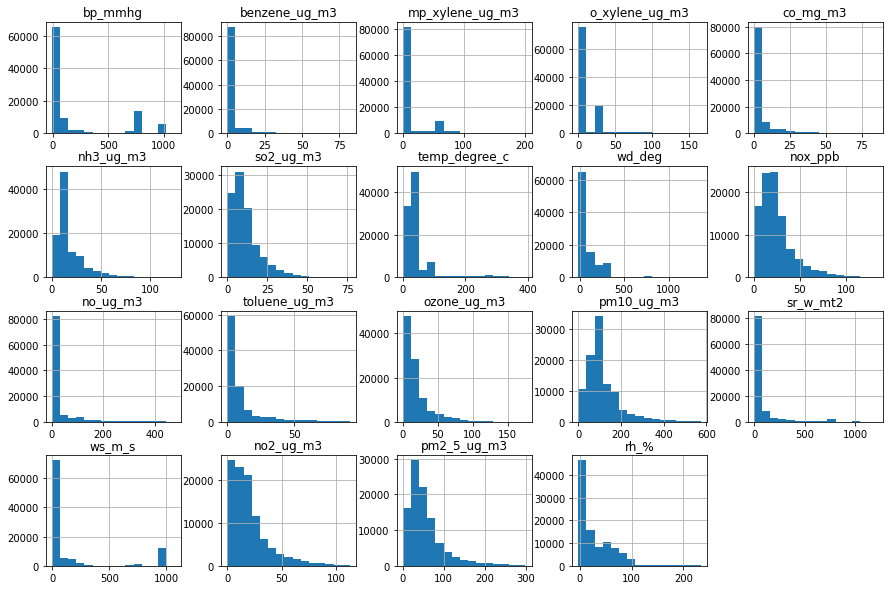

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas DataFrame for easy visualization
pandas_df = df_with_aqi.toPandas()

# Plot histograms for each numeric column
numeric_columns = [col for col in pandas_df.columns if pandas_df[col].dtype != 'object']

pandas_df[numeric_columns].hist(bins=15, figsize=(15, 10), layout=(4, 5))
plt.show()


### 1.2 Identify Correlations

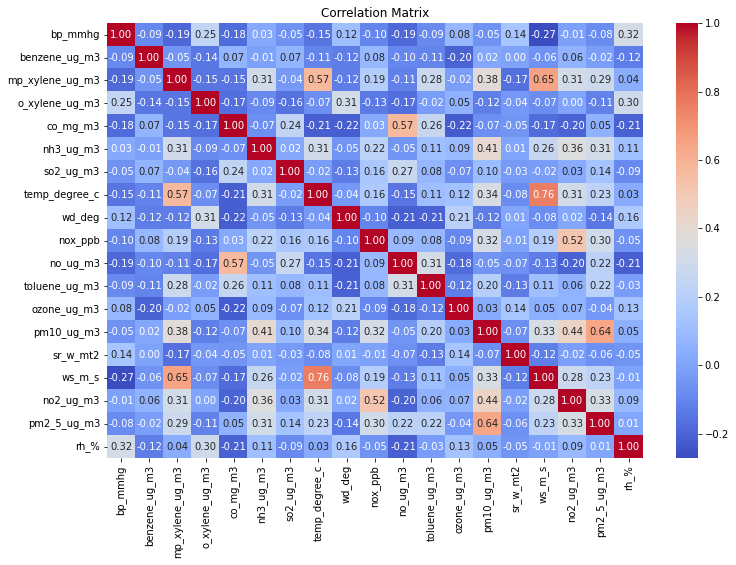

In [84]:
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = pandas_df[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


## Step 2: Data Visualization

### 2.1 Scatter Plots to Explore Relationships

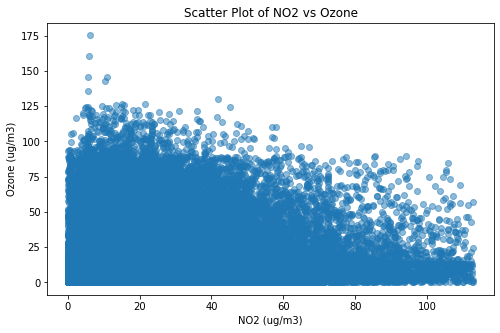

In [85]:
# Example: Scatter plot between 'no2_ug_m3' and 'ozone_ug_m3'
plt.figure(figsize=(8, 5))
plt.scatter(pandas_df['no2_ug_m3'], pandas_df['ozone_ug_m3'], alpha=0.5)
plt.title('Scatter Plot of NO2 vs Ozone')
plt.xlabel('NO2 (ug/m3)')
plt.ylabel('Ozone (ug/m3)')
plt.show()


### 2.2 Pair Plot to Explore Multiple Relationships

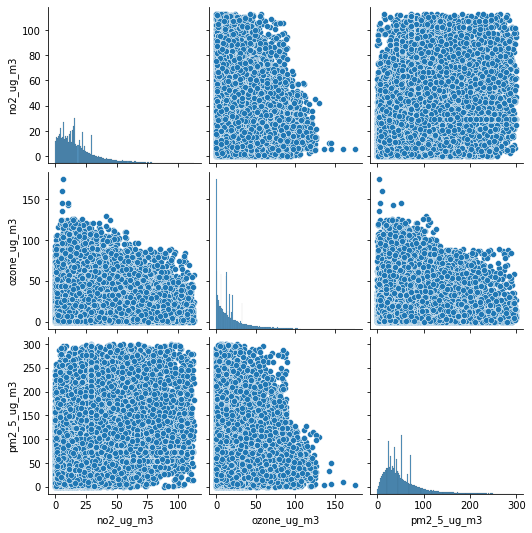

In [86]:
# Plot pair plot for a subset of features
sns.pairplot(pandas_df[['no2_ug_m3', 'ozone_ug_m3', 'pm2_5_ug_m3', 'AQI_Category']])
plt.show()

### 2.3 Categorical Analysis (e.g., AQI_Category Distribution)

+--------------+-----+
|  AQI_Category|count|
+--------------+-----+
|      Moderate|35671|
|     Unhealthy|30187|
|          Good|17040|
|Very Unhealthy| 9441|
|     Hazardous| 7661|
+--------------+-----+



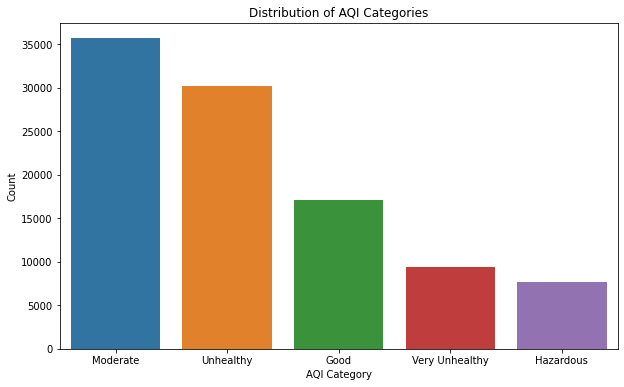

In [87]:
# Count the occurrences of each category
category_counts = df_with_aqi.groupBy("AQI_Category").count().orderBy("count", ascending=False)
category_counts.show()

# Convert to Pandas for plotting
category_counts_pd = category_counts.toPandas()

# Bar plot of AQI_Category distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='AQI_Category', y='count', data=category_counts_pd)
plt.title('Distribution of AQI Categories')
plt.xlabel('AQI Category')
plt.ylabel('Count')
plt.show()


## Step 3: Time-Series Visualization

### 5.1 Plotting Time-Series Trends

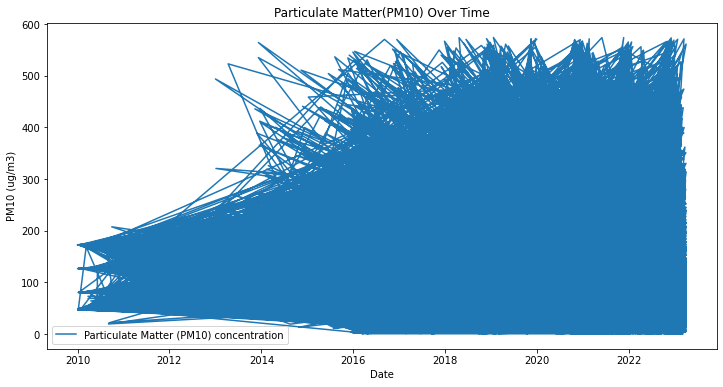

In [88]:
# Convert from_date and to_date to Pandas datetime format for easier manipulation
pandas_df['from_date'] = pd.to_datetime(pandas_df['from_date'])
pandas_df['to_date'] = pd.to_datetime(pandas_df['to_date'])

# Plot time-series for ozone concentration
plt.figure(figsize=(12, 6))
plt.plot(pandas_df['from_date'], pandas_df['pm10_ug_m3'], label='Particulate Matter (PM10) concentration')
plt.xlabel('Date')
plt.ylabel('PM10 (ug/m3)')
plt.title('Particulate Matter(PM10) Over Time')
plt.legend()
plt.show()


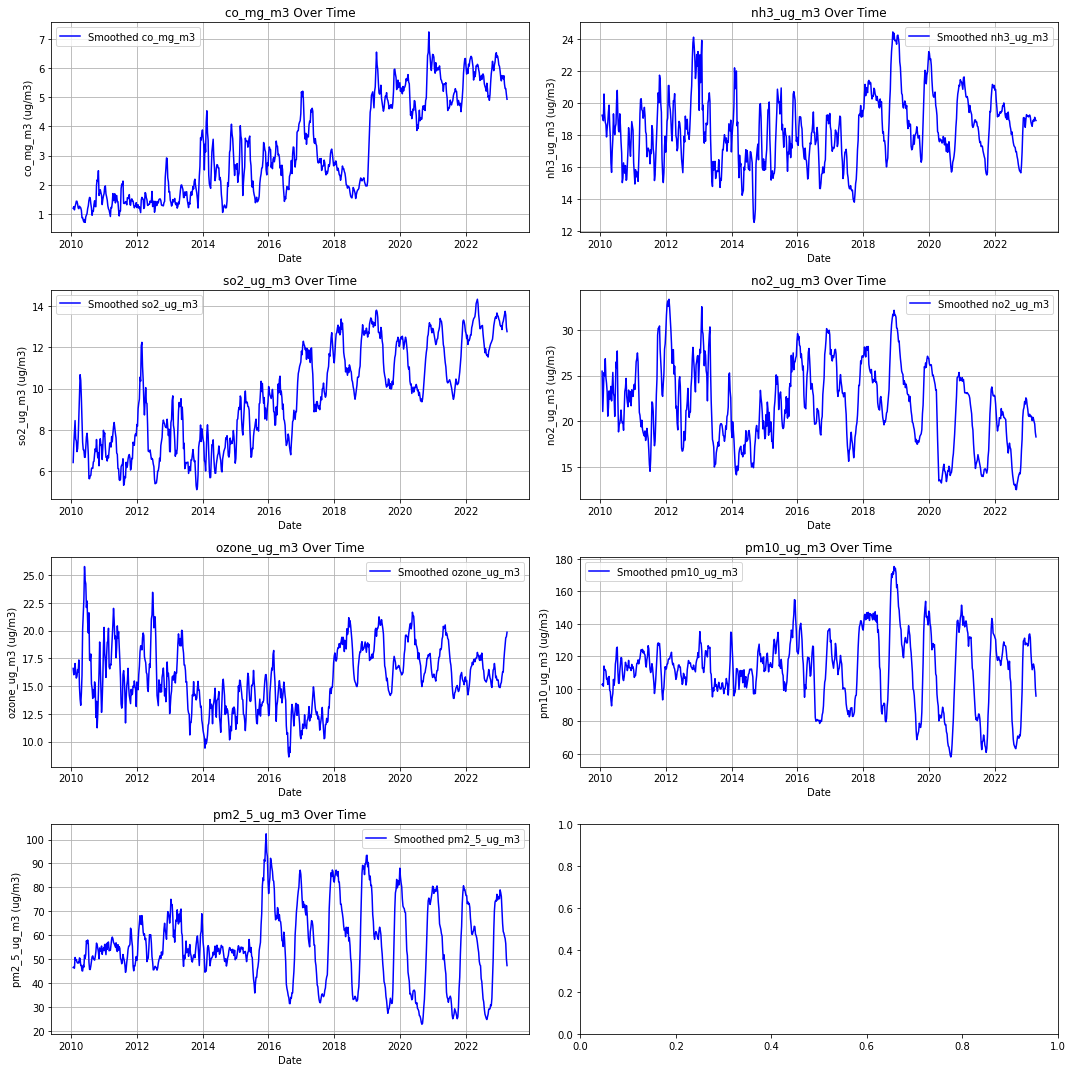

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'from_date' and 'to_date' to datetime if not already done
pandas_df['from_date'] = pd.to_datetime(pandas_df['from_date'])
pandas_df['to_date'] = pd.to_datetime(pandas_df['to_date'])

# List of columns to plot
columns_to_plot = ['co_mg_m3', 'nh3_ug_m3', 'so2_ug_m3', 'no2_ug_m3', 'ozone_ug_m3', 'pm10_ug_m3', 'pm2_5_ug_m3']

# Resample the data to a weekly mean to reduce noise
pandas_df_resampled = pandas_df.resample('W', on='from_date').mean()

# Apply a rolling mean to smooth the data further (optional)
for col in columns_to_plot:
    pandas_df_resampled[col + '_smoothed'] = pandas_df_resampled[col].rolling(window=4).mean()

# Set up the subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))
axes = axes.flatten()

# Plot each time series on a different subplot
for i, col in enumerate(columns_to_plot):
    ax = axes[i]
    ax.plot(pandas_df_resampled.index, pandas_df_resampled[col + '_smoothed'], label=f'Smoothed {col}', color='blue')
    ax.set_xlabel('Date')
    ax.set_ylabel(f'{col} (ug/m3)')
    ax.set_title(f'{col} Over Time')
    ax.grid(True)
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## Step 4. Augmented Dickey-Fuller (ADF) Test

### 4.1 Perform ADF Test for Stationarity

In [90]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test and print the results
def adf_test(timeseries):
    adf_result = adfuller(timeseries.dropna())
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
    for key, value in adf_result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

# Example usage on one column, say 'ozone_ug_m3'
adf_test(pandas_df['ozone_ug_m3'])


ADF Statistic: -316.343670
p-value: 0.000000
Critical Values:
   1%, -3.4304153953326493
Critical Values:
   5%, -2.8615689037124814
Critical Values:
   10%, -2.566785384434747


### 4.2. Plot Rolling Statistics
You can also visually inspect the time series to see if it looks stationary. One common method is to plot the rolling mean and standard deviation.

### Plot Rolling Mean and Standard Deviation

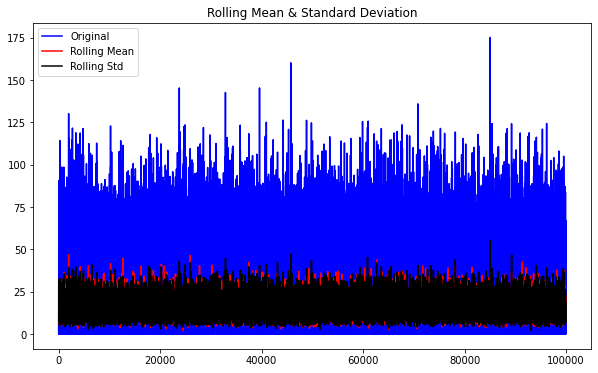

In [91]:
# Plot rolling statistics
def plot_rolling_statistics(timeseries, window=12):
    plt.figure(figsize=(10, 6))
    # Determine rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # Plot original time series, rolling mean, and rolling std
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# Example usage on one column, say 'ozone_ug_m3'
plot_rolling_statistics(pandas_df['ozone_ug_m3'])



Results for co_mg_m3:


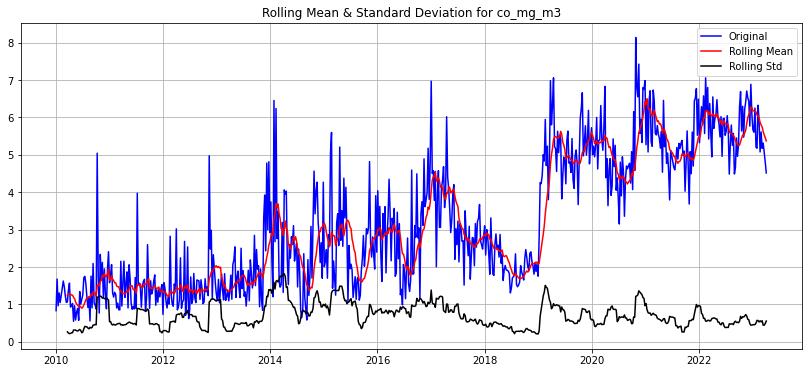

ADF Statistic for co_mg_m3: -2.165798751299184
p-value for co_mg_m3: 0.21889180353156934
Critical Values:
   1%: -3.4399324443722814
   5%: -2.865768564020576
   10%: -2.5690218258831052

Results for nh3_ug_m3:


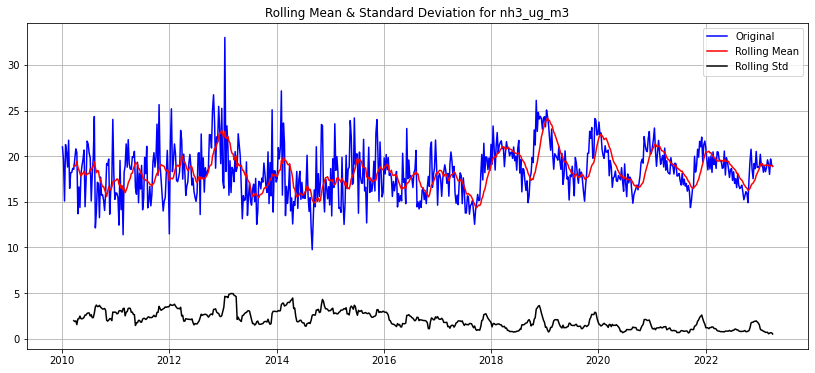

ADF Statistic for nh3_ug_m3: -6.935530822836277
p-value for nh3_ug_m3: 1.0570567467753245e-09
Critical Values:
   1%: -3.439890503006147
   5%: -2.865750085260771
   10%: -2.569011980884938

Results for so2_ug_m3:


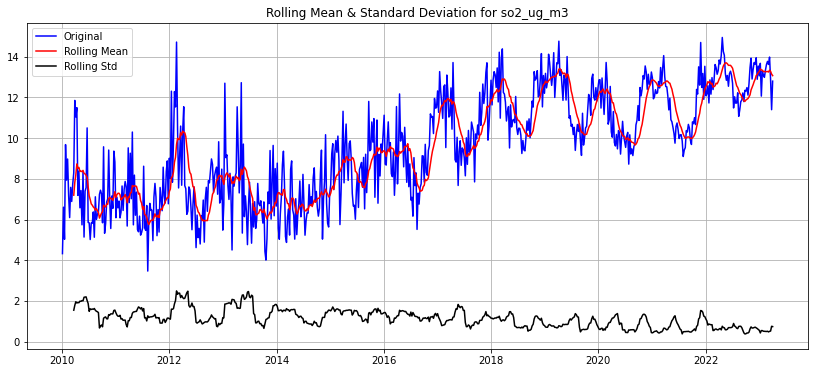

ADF Statistic for so2_ug_m3: -2.6625612648562966
p-value for so2_ug_m3: 0.08074386477132062
Critical Values:
   1%: -3.439918423003054
   5%: -2.865762386436236
   10%: -2.5690185346241785

Results for no2_ug_m3:


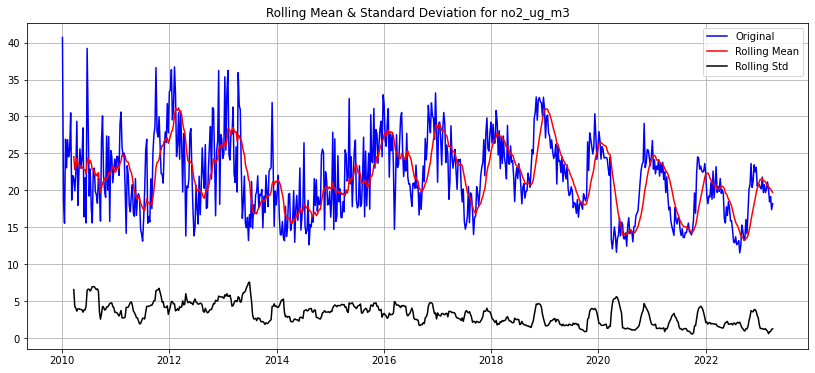

ADF Statistic for no2_ug_m3: -5.244139041520569
p-value for no2_ug_m3: 7.1397903585239235e-06
Critical Values:
   1%: -3.439890503006147
   5%: -2.865750085260771
   10%: -2.569011980884938

Results for ozone_ug_m3:


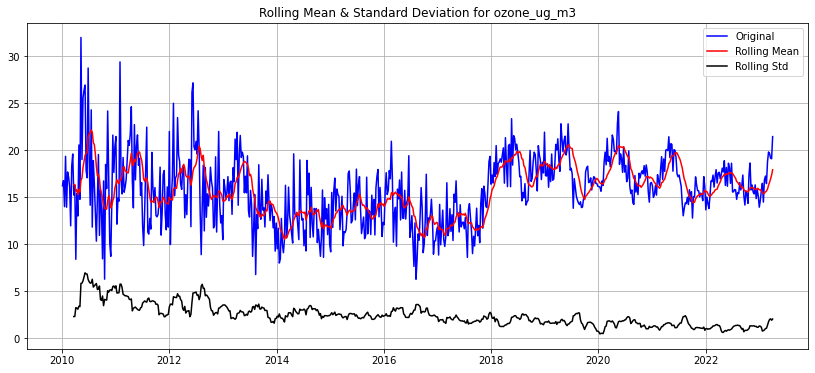

ADF Statistic for ozone_ug_m3: -3.9763552787430383
p-value for ozone_ug_m3: 0.0015395102982050518
Critical Values:
   1%: -3.4400317565062455
   5%: -2.8658123184971576
   10%: -2.56904513726821

Results for pm10_ug_m3:


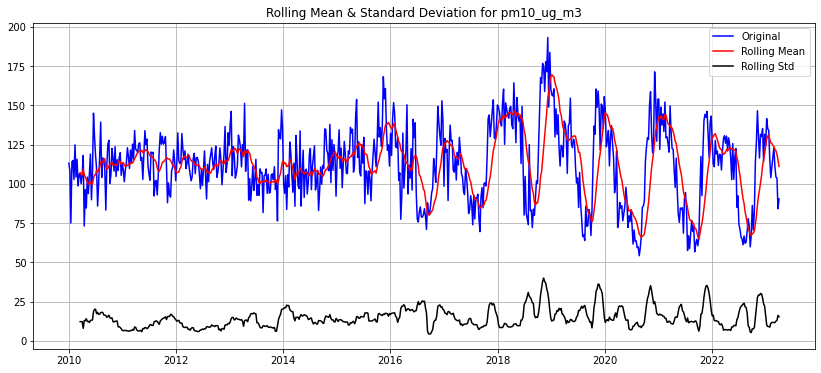

ADF Statistic for pm10_ug_m3: -7.099715495443038
p-value for pm10_ug_m3: 4.198789447708041e-10
Critical Values:
   1%: -3.4400174432106305
   5%: -2.8658060125001295
   10%: -2.569041777564251

Results for pm2_5_ug_m3:


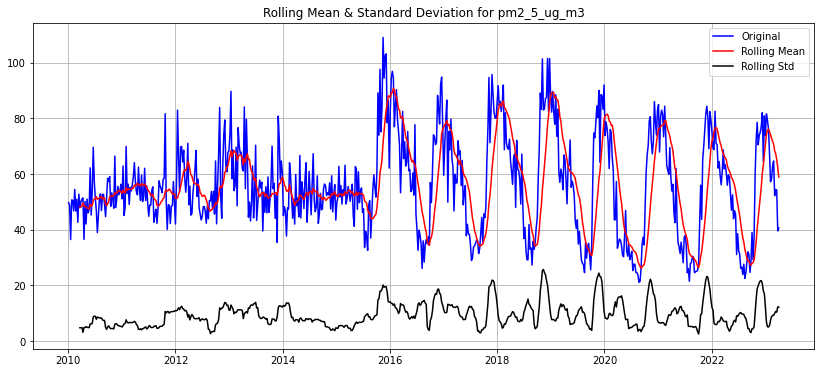

ADF Statistic for pm2_5_ug_m3: -7.63288632709967
p-value for pm2_5_ug_m3: 1.9872199725610903e-11
Critical Values:
   1%: -3.4400317565062455
   5%: -2.8658123184971576
   10%: -2.56904513726821


In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Convert 'from_date' to datetime if not already done
pandas_df['from_date'] = pd.to_datetime(pandas_df['from_date'])

# Resample to reduce noise (e.g., weekly)
pandas_df_resampled = pandas_df.resample('W', on='from_date').mean()

# Function to perform ADF test and plot rolling statistics
def plot_stationarity_check(timeseries, column_name, window=12):
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for {column_name}')
    plt.grid(True)
    plt.show()
    
    # ADF test
    adf_result = adfuller(timeseries.dropna())
    print(f'ADF Statistic for {column_name}: {adf_result[0]}')
    print(f'p-value for {column_name}: {adf_result[1]}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'   {key}: {value}')

# List of columns to check
columns_to_check = ['co_mg_m3', 'nh3_ug_m3', 'so2_ug_m3', 'no2_ug_m3', 'ozone_ug_m3', 'pm10_ug_m3', 'pm2_5_ug_m3']

# Iterate through the columns and plot/check each
for col in columns_to_check:
    print(f"\nResults for {col}:")
    plot_stationarity_check(pandas_df_resampled[col], col)


In [93]:
from pyspark.sql.functions import year, month, weekofyear, col, avg, count

# Convert 'from_date' to year, month, and week columns
df = df_with_aqi.withColumn("year", year(col("from_date"))) \
        .withColumn("month", month(col("from_date"))) \
        .withColumn("week", weekofyear(col("from_date")))

# Example 1: Year-wise Analysis
yearly_summary = df.groupBy("year").agg(
    avg("pm10_ug_m3").alias("avg_pm10"),
    avg("co_mg_m3").alias("avg_co"),
    count("AQI_Category").alias("count_aqi")
).orderBy("year")

yearly_summary.show()

# Example 2: Month-wise Analysis
monthly_summary = df.groupBy("year", "month").agg(
    avg("pm10_ug_m3").alias("avg_pm10"),
    avg("co_mg_m3").alias("avg_co"),
    count("AQI_Category").alias("count_aqi")
).orderBy("year", "month")

monthly_summary.show()

# Example 3: Week-wise Analysis
weekly_summary = df.groupBy("year", "week").agg(
    avg("pm10_ug_m3").alias("avg_pm10"),
    avg("co_mg_m3").alias("avg_co"),
    count("AQI_Category").alias("count_aqi")
).orderBy("year", "week")

weekly_summary.show()


+----+------------------+------------------+---------+
|year|          avg_pm10|            avg_co|count_aqi|
+----+------------------+------------------+---------+
|2010| 108.6588642925884|1.3875168431183889|     1039|
|2011|114.75202414772731| 1.412634943181825|     1408|
|2012|113.55155172413787|1.5573448275862085|     1450|
|2013|110.89811452513959|1.8044902234636873|     1432|
|2014|109.51981599999934|2.5557199999999884|     1250|
|2015|122.50635055940407|2.6029675013319067|     1877|
|2016|110.14793291404659| 3.010767295597482|     2385|
|2017|112.39768642951306|3.1569644268774564|     3795|
|2018|133.21513513513332|2.0570686070686035|     8177|
|2019|119.11190628327803| 5.120460391578604|    12207|
|2020|102.99660311844637|5.1799357966456565|    15264|
|2021|105.31152341739397| 5.333469377251537|    19430|
|2022|105.01619999146054| 5.856068912514294|    23421|
|2023|113.25799563000713| 5.392588492352515|     6865|
+----+------------------+------------------+---------+

+----+---

In [94]:
### 1. Yearly Trends Analysis

In [95]:
# Yearly average of pollutants
yearly_avg = df.groupBy("year").agg(
    avg("pm10_ug_m3").alias("avg_pm10"),
    avg("co_mg_m3").alias("avg_co"),
    avg("ozone_ug_m3").alias("avg_ozone")
).orderBy("year")
yearly_avg.show()


+----+------------------+------------------+------------------+
|year|          avg_pm10|            avg_co|         avg_ozone|
+----+------------------+------------------+------------------+
|2010| 108.6588642925884|1.3875168431183889|16.905803657362817|
|2011|114.75202414772731| 1.412634943181825|16.464190340909052|
|2012|113.55155172413787|1.5573448275862085|16.613441379310323|
|2013|110.89811452513959|1.8044902234636873|15.240600558659201|
|2014|109.51981599999934|2.5557199999999884|12.378535999999986|
|2015|122.50635055940407|2.6029675013319067| 13.88877464038355|
|2016|110.14793291404659| 3.010767295597482|13.174985324947597|
|2017|112.39768642951306|3.1569644268774564| 13.16711989459826|
|2018|133.21513513513332|2.0570686070686035|18.287172557172457|
|2019|119.11190628327803| 5.120460391578604|17.482430572622285|
|2020|102.99660311844637|5.1799357966456565|17.905508385744323|
|2021|105.31152341739397| 5.333469377251537| 16.55447503859985|
|2022|105.01619999146054| 5.856068912514

In [96]:
#### 2. AQI_Category Distribution

In [97]:
# Distribution of AQI categories over the years
aqi_distribution = df.groupBy("year", "AQI_Category").count().orderBy("year", "AQI_Category")
aqi_distribution.show()


+----+--------------+-----+
|year|  AQI_Category|count|
+----+--------------+-----+
|2010|          Good|  347|
|2010|     Hazardous|    9|
|2010|      Moderate|  150|
|2010|     Unhealthy|  518|
|2010|Very Unhealthy|   15|
|2011|          Good|  342|
|2011|     Hazardous|   22|
|2011|      Moderate|  264|
|2011|     Unhealthy|  748|
|2011|Very Unhealthy|   32|
|2012|          Good|  362|
|2012|     Hazardous|   37|
|2012|      Moderate|  287|
|2012|     Unhealthy|  664|
|2012|Very Unhealthy|  100|
|2013|          Good|  366|
|2013|     Hazardous|   26|
|2013|      Moderate|  305|
|2013|     Unhealthy|  623|
|2013|Very Unhealthy|  112|
+----+--------------+-----+
only showing top 20 rows



In [98]:
### 3.Pollution Spikes (Event-Based Analysis)

In [99]:
# Find days with pollution spikes
pollution_spikes = df.filter(col("pm10_ug_m3") > 100).orderBy(col("from_date"))
pollution_spikes.show()


+-------+-------------+---------------+--------------+--------+---------+---------+-------------+-------------------+-------------+------+-------+--------+-------------+-------------------+-----------+----------+--------+------+---------+-----------+-----+------------+----+-----+----+
|bp_mmhg|benzene_ug_m3|mp_xylene_ug_m3|o_xylene_ug_m3|co_mg_m3|nh3_ug_m3|so2_ug_m3|temp_degree_c|          from_date|        state|wd_deg|nox_ppb|no_ug_m3|toluene_ug_m3|            to_date|ozone_ug_m3|pm10_ug_m3|sr_w_mt2|ws_m_s|no2_ug_m3|pm2_5_ug_m3| rh_%|AQI_Category|year|month|week|
+-------+-------------+---------------+--------------+--------+---------+---------+-------------+-------------------+-------------+------+-------+--------+-------------+-------------------+-----------+----------+--------+------+---------+-----------+-----+------------+----+-----+----+
|    0.0|          1.9|          54.55|          0.97|    0.97|    29.23|     9.92|        100.0|2010-01-01 00:00:00|        Delhi| 34.96|   6

In [100]:
### 4.Hourly Patterns (Time-of-Day Analysis)

In [101]:
from pyspark.sql.functions import hour

# Extract hour from the timestamp
df_hourly = df.withColumn("hour", hour(col("from_date")))

# Calculate average pollutant levels per hour
hourly_avg = df_hourly.groupBy("hour").agg(
    avg("pm10_ug_m3").alias("avg_pm10"),
    avg("co_mg_m3").alias("avg_co")
).orderBy("hour")
hourly_avg.show()


+----+------------------+-----------------+
|hour|          avg_pm10|           avg_co|
+----+------------------+-----------------+
|   0|110.52762300000282|4.717116499999165|
+----+------------------+-----------------+



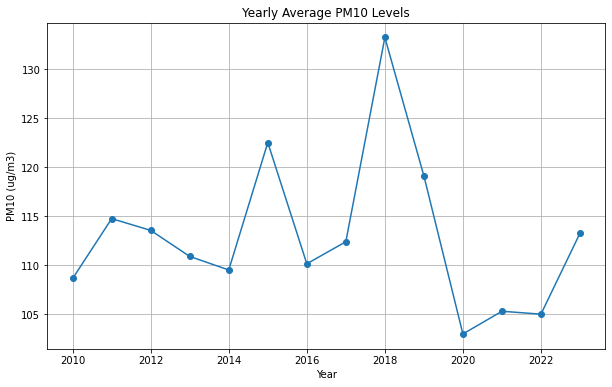

In [102]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for easy plotting
pandas_yearly_avg = yearly_avg.toPandas()

# Plot Yearly Average PM10 Levels
plt.figure(figsize=(10, 6))
plt.plot(pandas_yearly_avg['year'], pandas_yearly_avg['avg_pm10'], marker='o')
plt.title('Yearly Average PM10 Levels')
plt.xlabel('Year')
plt.ylabel('PM10 (ug/m3)')
plt.grid(True)
plt.show()


In [103]:
# Showing average pollutant levels by state
statewise_avg = df.groupBy("state").agg(
    avg("benzene_ug_m3").alias("avg_benzene"),
    avg("mp_xylene_ug_m3").alias("avg_mp_xylene"),
    avg("co_mg_m3").alias("avg_co"),
    avg("nh3_ug_m3").alias("avg_nh3"),
    avg("so2_ug_m3").alias("avg_so2"),
    avg("temp_degree_c").alias("avg_at"),
    avg("wd_deg").alias("avg_wd"),
    avg("no_ug_m3").alias("avg_no"),
    avg("toluene_ug_m3").alias("avg_toluene"),
    avg("rh_%").alias("avg_rh"),
    avg("ozone_ug_m3").alias("avg_ozone"),
    avg("pm10_ug_m3").alias("avg_pm10"),
    avg("ws_m_s").alias("avg_ws"),
    avg("no2_ug_m3").alias("avg_no2"),
    avg("pm2_5_ug_m3").alias("avg_pm2_5")
)

statewise_avg.toPandas()


,state,avg_benzene,avg_mp_xylene,avg_co,avg_nh3,avg_so2,avg_at,avg_wd,avg_no,avg_toluene,avg_rh,avg_ozone,avg_pm10,avg_ws,avg_no2,avg_pm2_5
0,Uttar Pradesh,0.878617,15.124312,1.173826,24.016795,10.371682,27.950000,107.088729,5.338824,16.030058,58.106558,17.459697,141.464272,7.803758,26.573062,64.987371
1,Tamil Nadu,0.191893,2.190000,0.802411,14.713974,6.971532,35.151463,146.933024,5.887186,0.261154,58.940565,23.168395,50.518310,51.773187,13.368606,30.751502
2,Maharashtra,17.424748,3.630199,7.880930,15.830000,13.260348,5.240703,28.520040,10.486273,1.563160,7.507136,0.819906,90.403638,34.037018,19.726193,40.069829
3,Delhi,2.366555,51.905550,1.084677,30.503718,11.617865,123.084633,66.190726,13.376515,15.199268,31.475779,19.258744,189.476110,709.621323,35.005912,88.722090
4,Gujarat,11.740738,0.806090,6.897598,15.830000,18.311265,27.950000,89.596602,8.090851,2.995510,42.333031,0.842239,96.962858,23.615793,17.676249,48.943451
5,Haryana,0.754260,2.190000,22.478607,15.830000,16.727293,3.755891,3.441337,118.274715,20.516681,13.294636,8.401511,90.500000,1.976522,8.273781,62.303889
6,West Bengal,4.319053,1.574624,0.604325,16.682620,8.950529,27.950000,34.960000,7.286685,7.043328,44.989411,24.108899,101.986728,63.534828,23.893211,49.554678
7,Madhya Pradesh,1.783340,2.190000,0.658564,13.114382,9.794348,33.916246,119.427400,5.300102,2.822324,22.342554,35.402034,100.194369,5.402416,18.390864,38.292360
8,Kerala,0.800000,2.190000,0.738901,6.195249,4.115063,10.032477,56.783169,9.197993,3.980000,0.540552,18.000127,51.933802,39.159982,12.905854,26.351686
9,Mizoram,0.025517,0.133153,0.283448,11.729409,10.103202,27.950000,34.960000,4.344778,3.980000,71.708571,3.812365,33.922365,1.326700,0.478818,8.471527


In [104]:
# Counting records by AQI Category and state
statewise_aqi_count = df.groupBy("state", "AQI_Category").count().orderBy("state")

# Display the results
statewise_aqi_count.show()


+-----------------+--------------+-----+
|            state|  AQI_Category|count|
+-----------------+--------------+-----+
|   Andhra Pradesh|      Moderate|  460|
|   Andhra Pradesh|     Hazardous|   12|
|   Andhra Pradesh|     Unhealthy|  229|
|   Andhra Pradesh|          Good|  295|
|Arunachal Pradesh|      Moderate|   26|
|Arunachal Pradesh|     Unhealthy|    4|
|Arunachal Pradesh|          Good|   48|
|            Assam|          Good|  144|
|            Assam|Very Unhealthy|   79|
|            Assam|     Hazardous|   67|
|            Assam|     Unhealthy|  108|
|            Assam|      Moderate|  213|
|            Bihar|Very Unhealthy|  980|
|            Bihar|     Unhealthy| 1573|
|            Bihar|      Moderate| 2260|
|            Bihar|     Hazardous|  487|
|       Chandigarh|          Good|   87|
|       Chandigarh|     Unhealthy|  173|
|       Chandigarh|      Moderate|  183|
|       Chandigarh|     Hazardous|   41|
+-----------------+--------------+-----+
only showing top

In [105]:
# Filtering data for a specific state (e.g., "Delhi")
Odisha_data = df.filter(df.state == "Andhra Pradesh")

# Show the filtered data
Odisha_data.toPandas()


,bp_mmhg,benzene_ug_m3,mp_xylene_ug_m3,o_xylene_ug_m3,co_mg_m3,nh3_ug_m3,so2_ug_m3,temp_degree_c,from_date,state,...,pm10_ug_m3,sr_w_mt2,ws_m_s,no2_ug_m3,pm2_5_ug_m3,rh_%,AQI_Category,year,month,week
0,251.00,2.27,2.19,2.65,0.72,20.00,14.05,28.62,2020-12-22,Andhra Pradesh,...,141.75,1.17,24.83,22.82,87.00,0.10,Unhealthy,2020,12,52
1,78.50,0.10,2.19,2.65,0.40,10.82,11.48,28.62,2021-04-12,Andhra Pradesh,...,26.25,0.50,26.23,7.02,10.25,0.10,Good,2021,4,15
2,218.50,0.00,2.19,2.65,0.00,0.45,7.75,28.62,2017-10-15,Andhra Pradesh,...,61.25,0.00,2.07,17.05,27.00,41.00,Moderate,2017,10,41
3,147.50,0.00,2.19,2.65,1.02,4.23,6.13,28.62,2018-05-01,Andhra Pradesh,...,36.00,6.88,21.12,2.33,15.75,0.10,Good,2018,5,18
4,30.83,0.01,2.19,2.65,0.28,0.31,4.03,0.10,2022-12-02,Andhra Pradesh,...,46.01,0.36,0.20,17.05,19.17,0.29,Good,2022,12,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,203.75,1.12,2.19,2.65,0.61,11.60,17.23,28.62,2021-11-08,Andhra Pradesh,...,109.25,0.35,32.48,35.42,56.75,0.15,Unhealthy,2021,11,45
992,254.75,0.20,2.19,2.65,0.85,15.25,6.17,28.62,2018-07-12,Andhra Pradesh,...,21.00,6.77,29.67,3.12,13.00,0.10,Good,2018,7,28
993,94.50,0.00,2.19,2.65,0.00,4.62,7.75,28.62,2020-04-28,Andhra Pradesh,...,26.00,5.65,26.30,4.48,13.00,0.10,Good,2020,4,18
994,80.00,1.20,2.19,2.65,1.11,17.00,7.75,28.62,2019-12-28,Andhra Pradesh,...,119.75,4.00,25.70,10.40,87.75,0.10,Unhealthy,2019,12,52


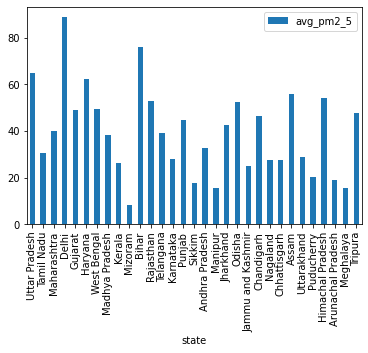

In [106]:
# Collect data to Pandas DataFrame for visualization
import pandas as pd

statewise_avg_pd = statewise_avg.toPandas()

# Now you can use matplotlib or seaborn for visualization
import matplotlib.pyplot as plt

statewise_avg_pd.plot(kind='bar', x='state', y='avg_pm2_5')
plt.show()


<Figure size 720x432 with 0 Axes>

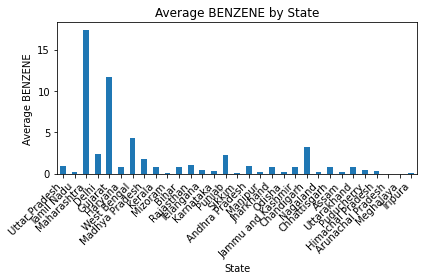

<Figure size 720x432 with 0 Axes>

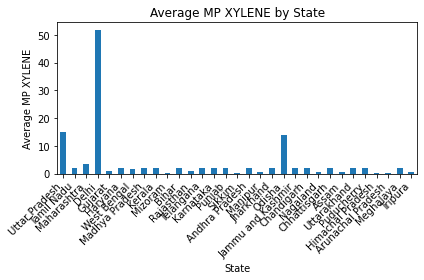

<Figure size 720x432 with 0 Axes>

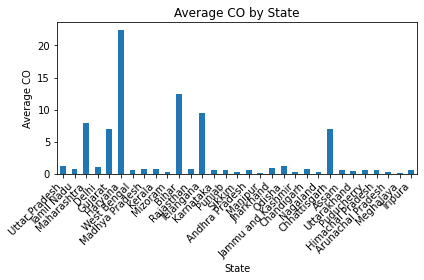

<Figure size 720x432 with 0 Axes>

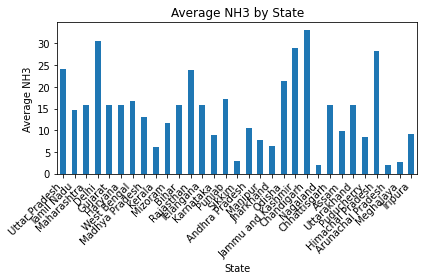

<Figure size 720x432 with 0 Axes>

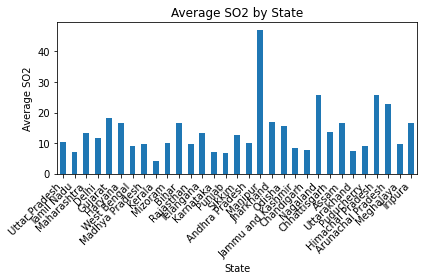

<Figure size 720x432 with 0 Axes>

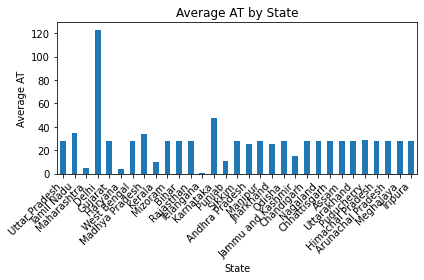

<Figure size 720x432 with 0 Axes>

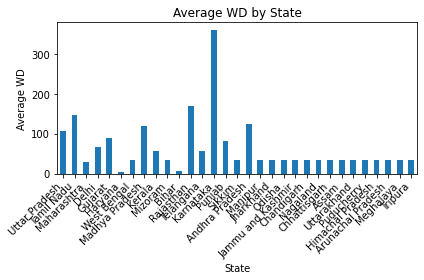

<Figure size 720x432 with 0 Axes>

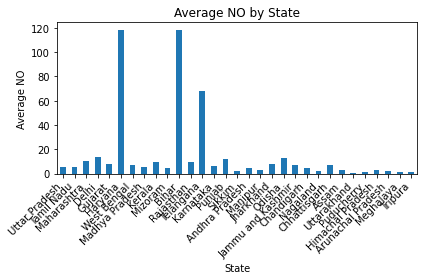

<Figure size 720x432 with 0 Axes>

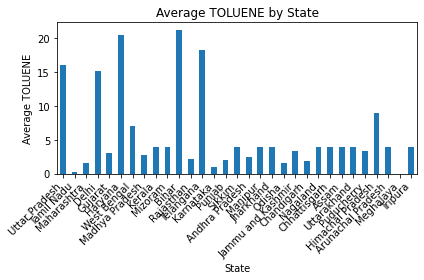

<Figure size 720x432 with 0 Axes>

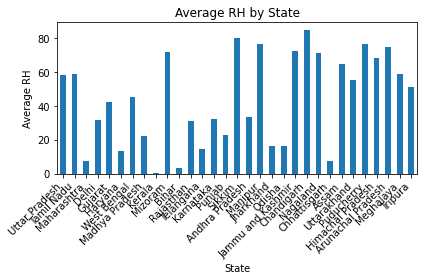

<Figure size 720x432 with 0 Axes>

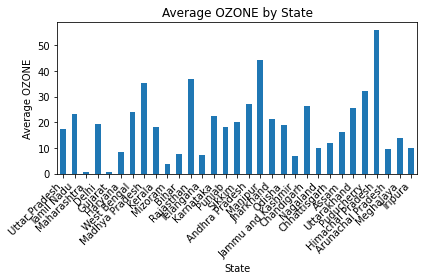

<Figure size 720x432 with 0 Axes>

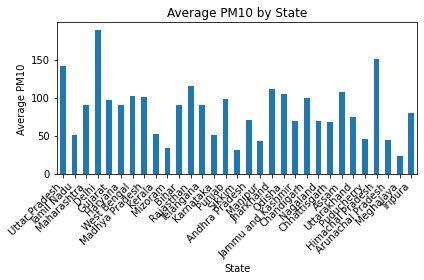

<Figure size 720x432 with 0 Axes>

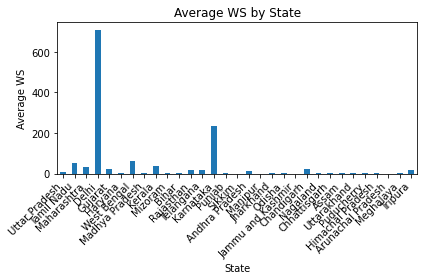

<Figure size 720x432 with 0 Axes>

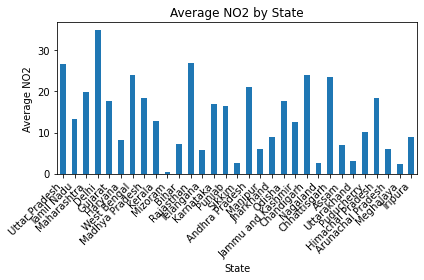

<Figure size 720x432 with 0 Axes>

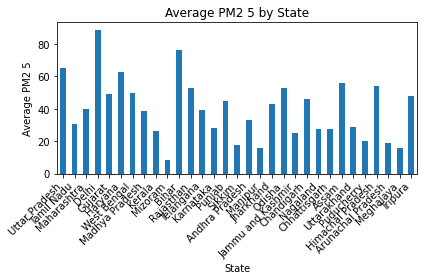

In [107]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt

# Assuming statewise_avg is your DataFrame with average pollutant values by state
statewise_avg_pd = statewise_avg.toPandas()

# List of pollutants to plot
pollutants = [
    "avg_benzene", 
    "avg_mp_xylene", 
    "avg_co", 
    "avg_nh3", 
    "avg_so2", 
    "avg_at", 
    "avg_wd", 
    "avg_no", 
    "avg_toluene", 
    "avg_rh",  
    "avg_ozone", 
    "avg_pm10", 
    "avg_ws", 
    "avg_no2", 
    "avg_pm2_5"
]

# Iterating over each pollutant to create bar plots
for pollutant in pollutants:
    plt.figure(figsize=(10, 6))
    statewise_avg_pd.plot(kind='bar', x='state', y=pollutant, legend=False)
    plt.title(f'Average {pollutant.replace("avg_", "").replace("_", " ").upper()} by State')
    plt.ylabel(f'Average {pollutant.replace("avg_", "").replace("_", " ").upper()}')
    plt.xlabel('State')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [108]:
df.unpersist()
spark.stop()